In [1]:
import os
import requests
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import transformers
from peft import get_peft_model, PrefixTuningConfig, TaskType
from transformers import Trainer, TrainingArguments
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from PIL import Image
from tqdm import tqdm
from transformers import AutoTokenizer
import numpy as np
from torchvision import transforms

In [2]:
def build_filtered_dataset(dataset_name='derek-thomas/ScienceQA',
                           split='train',
                           keep_grades='1-6'):
    """
    构建按年级和图像存在性过滤的数据集。

    参数:
        dataset_name (str): 数据集名称，例如 'derek-thomas/ScienceQA'。
        split (str): 数据分割，例如 'train', 'test', 'validation'。
        keep_grades (str or None): 筛选的年级段："1-6"、"7-12" 或 None 表示不过滤。

    返回:
        List[Dict]: 筛选后的样本列表。
    """

    def is_grade_allowed(grade_str):
        if keep_grades is None:
            return True
        try:
            grade_num = int(grade_str.replace("grade", ""))
            if keep_grades == "1-6":
                return 1 <= grade_num <= 6
            elif keep_grades == "7-12":
                return 7 <= grade_num <= 12
        except:
            return False
        return False



    data = load_dataset(dataset_name, split=split)
    dataset = []

    for i, sample in enumerate(data):
        try:
            if sample.get('question') is None:
                continue
            
            if sample.get("image", None) is None:
                continue

            if not is_grade_allowed(sample.get("grade", "")):
                continue

            solution = sample.get("solution", "")
            lecture = sample.get("lecture", "")
            solution_lecture = f"{solution}\n\n{lecture}".strip()
            
            image = sample["image"].convert("RGB")
            

            # image = np.array(image)
            # image = torch.tensor(image).permute(2, 0, 1)  # shape: (C, H, W)
            dataset.append({
                "image": image, 
                "question": sample["question"],
                "choices": sample["choices"],
                "hint": sample["hint"],
                "answer": sample["answer"],
                "solution_lecture": solution_lecture,
                'grade':sample["grade"],
            })
            
        except Exception as e:
            print(f"跳过第 {i} 个样本，错误：{e}")
            continue
    return dataset

In [10]:
from torch.utils.data import Dataset
from PIL import Image

class QwenVLPrefixDataset(Dataset):
    def __init__(self, data_list, max_label_length=256, debug=False):
        self.data_list = data_list
        self.max_label_length = max_label_length
        self.debug = debug

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]

        # 清洗文本换行符
        def clean(text):
            return text.strip().replace('\n', ' ').replace('\r', ' ')

        # 1. 答案编号（0~3）
        if isinstance(sample["answer"], int):
            answer_index = sample["answer"]
        else:
            answer_index = sample["choices"].index(sample["answer"])
        answer_letter = chr(65 + answer_index)

        # 2. 构造文本 prompt（清洗 question、choices、hint）
        question_text = f"Question: {clean(sample['question'])}\n"
        for i, choice in enumerate(sample["choices"]):
            question_text += f"{chr(65 + i)}. {clean(choice)}\n"
        if sample.get("hint"):
            question_text += f"\nHint: {clean(sample['hint'])}\n"
        question_text += (
            "\nThen, explain your reasoning in detail. "
            )

        # 3. 图像处理
        image = sample["image"]
        if not isinstance(image, Image.Image):
            raise ValueError("image must be a PIL.Image.Image")
        image = image.convert("RGB").resize((224, 224))

        # 4. 返回内容
        return {
            "image": image,
            "answer": sample["answer"],
            "text_prompt": question_text,
            "answer_index": answer_index,
            "answer_letter": answer_letter,
            "question": clean(sample["question"]),
            "choices": [clean(c) for c in sample["choices"]],
            "solution_lecture": 'The right answare is ' + answer_letter + ' ' + sample.get("solution_lecture", "").strip()
        }


==== TEXT PROMPT ====
Question: Which of the following could Gordon's test show?
A. if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour
B. how steady a parachute with a 1 m vent was at 200 km per hour
C. whether a parachute with a 1 m vent would swing too much at 400 km per hour

Hint: People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design. The passage below describes how the engineering-design process was used to test a solution to a problem. Read the passage. Then answer the question below.  Gordon was an aerospace engineer who was developing a parachute for a spacecraft that would land on Mars. He needed to add a vent at the center of the parachute so the spacecraft would land smoothly. However, the spacecraft would have to travel at a high speed before landing. If the vent was too big or too small, the parachute might swing 

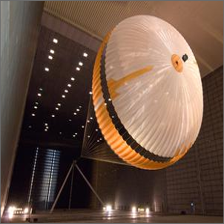


Explanation (Ground Truth):
Ground Truth: B
The right answare is B People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design. How can you determine what a test can show? You need to figure out what was tested and what was measured.
Imagine an engineer needs to design a bridge for a windy location. She wants to make sure the bridge will not move too much in high wind. So, she builds a smaller prototype, or model, of a bridge. Then, she exposes the prototype to high winds and measures how much the bridge moves.
First, identify what was tested. A test can examine one design, or it may compare multiple prototypes to each other. In the test described above, the engineer tested a prototype of a bridge in high wind.
Then, identify what the test measured. One of the criteria for the bridge was that it not move too much in high winds. The test measured how much the prototype br

In [ ]:
from tqdm import tqdm

dataset = QwenVLPrefixDataset(dataset_test)

sample = dataset[122]
print("==== TEXT PROMPT ====")
print(sample["text_prompt"])
sample["image"].show()
print("\nExplanation (Ground Truth):")
print("Ground Truth:", sample["answer_letter"])
print(sample["solution_lecture"])

In [20]:
import torch
from tqdm import tqdm
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import warnings
import pandas as pd

# 初始化
smooth_fn = SmoothingFunction().method1
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
warnings.filterwarnings("ignore", message="Both `max_new_tokens`*")


def parse_answer_and_explanation(text):
    """
    从模型输出中提取答案字母和解释部分。
    支持格式：
        - Answer: A
        - Answer is A
        - A. Explanation
        - A) Explanation
        - (A) Explanation
        - [A] Explanation
        - 中文也可轻松扩展
    返回：
        answer_index: int (0-3 对应 A-D)，未识别为 -1
        explanation: str
    """
    text = text.strip()

    # 多种格式匹配
    match = re.search(
        r"(?i)\b(?:answer|ans|answare)?\s*(?:is|:|-|=)?\s*[\(\[\s]*([A-D])[\)\]\s]*[\.\:\)\-]?",
        text
    )

    if match:
        answer_char = match.group(1).upper()
        answer_index = ord(answer_char) - ord("A")
        start_idx = match.end()
    else:
        answer_index = -1
        start_idx = 0

    explanation = text[start_idx:].strip()
    return answer_index, explanation

def keyword_overlap(pred, ref):
    pred_words = set(re.findall(r"\w+", pred.lower()))
    ref_words = set(re.findall(r"\w+", ref.lower()))
    return len(pred_words & ref_words) / len(ref_words) if ref_words else 0.0

def evaluate_blip2_generation(model, processor, dataset, device="cuda", max_samples=None):
    """
    用于评估 BLIP2 模型的选择题回答与解释文本质量
    """
    correct = 0
    total = 0
    bleu1_list, bleu4_list = [], []
    rougeL_list, keyword_overlap_list = [], []
    results_per_sample = []

    print("开始推理并评估...")
    for i, sample in enumerate(tqdm(dataset)):
        if max_samples and i >= max_samples:
            break

        # 数据准备
        image = sample["image"].convert("RGB")
        question = sample["text_prompt"]
        gt_index = sample["answer_index"]
        gt_letter = sample["answer_letter"]
        ref_explanation = sample.get("solution_lecture", "").strip()

        # 构建完整 prompt
        prompt = f"{question}\nAnswer:"
        # print(f"Prompt: {prompt}")
        # 推理
        try:
            inputs = processor(images=image, text=prompt, return_tensors="pt").to(device=device, dtype=torch.float16)
            with torch.no_grad():
                generated_ids = model.generate(**inputs, max_new_tokens=100)
                output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        except Exception as e:
            print(f"❌ 推理失败 (sample {i}): {e}")
            continue

        # 解析预测
        pred_index, pred_explanation = parse_answer_and_explanation(output_text)
        if pred_index == gt_index:
            correct += 1
        total += 1

        # 指标计算
        ref_tokens = ref_explanation.split()
        pred_tokens = pred_explanation.split()
        bleu1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        bleu4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)
        rougeL = rouge.score(ref_explanation, pred_explanation)["rougeL"].fmeasure
        keyword_score = keyword_overlap(pred_explanation, ref_explanation)

        # 记录单条
        results_per_sample.append({
            "id": i,
            "question": sample.get("question", ""),
            "choices": " | ".join(sample.get("choices", [])),
            "hint": sample.get("hint", ""),
            "ground_truth_answer": gt_letter,
            "predicted_answer": chr(65 + pred_index) if pred_index >= 0 else "N/A",
            "predicted_text": output_text,
            "predicted_explanation": pred_explanation,
            "reference_explanation": ref_explanation,
            "BLEU-1": round(bleu1, 4),
            "BLEU-4": round(bleu4, 4),
            "ROUGE-L": round(rougeL, 4),
            "Keyword Overlap": round(keyword_score, 4)
        })

        # 指标汇总
        bleu1_list.append(bleu1)
        bleu4_list.append(bleu4)
        rougeL_list.append(rougeL)
        keyword_overlap_list.append(keyword_score)

    # 统计输出
    acc = correct / total if total > 0 else 0.0
    print("\n=== 总体结果 ===")
    print(f"Accuracy:         {acc:.2%} ({correct}/{total})")
    print(f"BLEU-1:           {sum(bleu1_list)/total:.4f}")
    print(f"BLEU-4:           {sum(bleu4_list)/total:.4f}")
    print(f"ROUGE-L:          {sum(rougeL_list)/total:.4f}")
    print(f"Keyword Overlap:  {sum(keyword_overlap_list)/total:.4f}")

    # 写入 CSV
    df = pd.DataFrame(results_per_sample)
    df.to_csv("instructblip-vicuna-7b_scienceQA_1_6.csv", index=False)
    print("📄 已保存评估结果到instructblip-vicuna-7b_1_6.csv")

    return {
        "accuracy": acc,
        "bleu1": sum(bleu1_list)/total,
        "bleu4": sum(bleu4_list)/total,
        "rougeL": sum(rougeL_list)/total,
        "keyword_overlap": sum(keyword_overlap_list)/total
    }


In [21]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch
from PIL import Image
import requests
# 1. 加载模型与 processor
# model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b")
# processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

# # 2. 构造 Dataset 实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 把模型移到设备
model = model.to(device)
dataset_test = build_filtered_dataset(split='test', keep_grades='1-6')
dataset = QwenVLPrefixDataset(dataset_test)

results = evaluate_blip2_generation(model, processor, dataset, device="cuda", max_samples=len(dataset))

开始推理并评估...


 42%|████▏     | 597/1429 [14:12<14:55,  1.08s/it]  

❌ 推理失败 (sample 596): CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 31.74 GiB of which 12.12 MiB is free. Process 58578 has 31.72 GiB memory in use. Of the allocated memory 30.15 GiB is allocated by PyTorch, and 435.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 1429/1429 [34:02<00:00,  1.43s/it]


=== 总体结果 ===
Accuracy:         28.08% (401/1428)
BLEU-1:           0.1485
BLEU-4:           0.0462
ROUGE-L:          0.1806
Keyword Overlap:  0.3354
📄 已保存评估结果到instructblip-vicuna-7b_1_6.csv


In [ ]:
# from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
# from transformers import Blip2Processor, Blip2ForConditionalGeneration
# from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
# from PIL import Image
# import torch
# import requests
# processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b-coco")

# # model = Blip2ForConditionalGeneration.from_pretrained(
# #     "Salesforce/blip2-opt-2.7b-coco", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
# # )  # doctest: +IGNORE_RESULT

# url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png'
# image = Image.open(requests.get(url, stream=True).raw)

# prompt = (
#     "Question: What is this?\n"
#     "Choices: A. A lion  B. A fish  C. A Merlion  D. A dolphin\n"
#     "Please choose the best answer and explain why step by step.\n"
#     "Answer:"
# )

# inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

# generated_ids = model.generate(**inputs,max_new_tokens=50)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
# print(generated_text)


Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question: What is this?
Choices: A. A lion  B. A fish  C. A Merlion  D. A dolphin
Please choose the best answer and explain why step by step.
Answer: A. A lion  Explanation: The lion is a symbol of the city of singapore. The lion is a symbol of the city of singapore. The lion is a symbol of the city of singapore. The lion is a symbol of
